Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import gdown
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report
tqdm.pandas()

%matplotlib inline

Download data

In [2]:
! rm -r *
gdown.download(url='https://drive.google.com/uc?id=1i__vau9jJdejh1T87U34BqZjq4j8I7sC', output='Data.zip', quiet=True)
gdown.download(url='https://drive.google.com/uc?id=123C0ind9WHa3Ep7VEWpGTItFuEHuygFR', output='added_data.xlsx', quiet=True)
gdown.download(url='https://drive.google.com/uc?id=1N46G6pbPIPay4FpBxGio8Tgd6dmTTuJD', output='labeled_data_1.csv', quiet=True)
gdown.download(url='https://drive.google.com/uc?id=1EEEbTTsvv_JwOELTeQmIceGgPNwqwv8Z', output='defined_lexicon_1.csv', quiet=True)
! unzip -q Data.zip
! rm Data.zip

Read data

In [3]:
df1 = pd.read_excel('added_data.xlsx')
df1.drop_duplicates(keep=False, inplace=True)
df1.dropna(axis=0, inplace=True)
classes = {'NOT': 0, 'ABUSIVE': 1}
df1['class'] = df1['class'].map(classes)
df1.head()


,tweet,class
0,malaya wa kihaya,1
1,Malaya mbovu mbona tunakujua,1
2,Malaya mzee bibi umechoka,1
3,Mbwa jike wewe!,1
4,mkundu unakuwasha wewe,1


In [4]:
df2 = pd.read_csv('labeled_data_1.csv', encoding='latin1')
# remove index column (not informative)
df2.drop(['index'], axis=1, inplace=True)
# # remove duplicate rows if any, keep one out of the duplicates
df2.drop_duplicates(keep=False, inplace=True)
# remove blank rows if any.
df2.dropna(axis=0, inplace=True)
# rename class text values  to numeric value
classes = {'NOT': 0, 'ABUSIVE': 1}
df2['class'] = df2['class'].map(classes)
df2.head()

,tweet,class
0,Jaman Nime Miss nini watu wangu wa Twitter .. ...,0
1,amka asubuhi Piga mswaki nusu saa oga nusu saa...,0
2,Vipi umepata BWANA?,0
3,@Divathebawse we unafanyaga ivo au unafanyiwa?,0
4,Million 500 inaanza kutumika kwenye uchumba,0


In [5]:
#concatenate the two dfs
df = pd.concat([df1, df2])

# shuffle df
df = shuffle(df)

In [6]:
len(df) # number of rows on the dataset

999

In [7]:
df['class'].value_counts() # count value for each class

0    533
1    466
Name: class, dtype: int64

In [8]:
FLAGS = re.MULTILINE | re.DOTALL
stopwords = ['na', 'ya', 'ni', 'au', 'wewe']

def clean_text(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>") # remove urls
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "") # removed <user>
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "") #removed <number>
    return text.lower()

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese characters
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"    
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocess_text(text):
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    # remove single character
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    # removing multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

def pre_process_text(text):
    text = str(text)
    text = clean_text(text)
    text = remove_emoji(text)
    text = preprocess_text(text)
    # remove stopwords
    # text = ' '.join([word for word in text.split() if word not in stopwords])
    return text.strip()

In [9]:
df.tweet = df.tweet.progress_apply(pre_process_text)

100%|██████████| 999/999 [00:00<00:00, 24573.84it/s]


In [10]:
df.head()

,tweet,class
86,ungejaribu kulala nao uangalie kama bado wananuka,0
610,mungu ni mwema atakunyoosha utabaki mweupee ka...,0
387,hebu jitie kidole alafu weka juu uone kama nzi...,1
24,muulize bwana wako,0
617,kwann usiviendeleze hence job creation ukakimb...,0


Spliting data

In [11]:
RANDOM_SEED=123
test_size = 0.2

def split_data(df):
    df_train, df_valid  = train_test_split(df, test_size=test_size, random_state=RANDOM_SEED)

    x_train, y_train = df_train.tweet.values, df_train['class'].values.astype('int')
    x_valid, y_valid = df_valid.tweet.values, df_valid['class'].values.astype('int')
    return (x_train, y_train ), (x_valid, y_valid)

In [12]:
(x_train, y_train ), (x_valid, y_valid) = split_data(df)

In [13]:
# vectorize words by using TF-IDF Vectorizer, This is for finding how important a word in document is in comaprison to the corpus
Tfidf_vect = TfidfVectorizer(max_features=800)
Tfidf_vect.fit(df['tweet'])

x_train_Tfidf = Tfidf_vect.transform(x_train)
x_valid_Tfidf = Tfidf_vect.transform(x_valid)

## Naive Bayes

Using Tf-IDF

In [14]:
naive_clf = MultinomialNB()
naive_clf.fit(x_train_Tfidf,y_train)
 
naive_preds = naive_clf.predict(x_valid_Tfidf)
 
accuracy = accuracy_score(naive_preds, y_valid)
f_score = f1_score(naive_preds, y_valid)
 
print(f'''Naive Bayes
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

Naive Bayes
Accuracy: 0.74
f1_score: 0.72


In [15]:
print(classification_report(y_valid, naive_preds, target_names=classes))

              precision    recall  f1-score   support

         NOT       0.78      0.75      0.76       110
     ABUSIVE       0.71      0.73      0.72        90

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.75      0.74      0.75       200



Using combination of features

In [16]:
text_clf = Pipeline([
    ('text features', FeatureUnion(
        [('vect', CountVectorizer()),
         ('tfidf', Pipeline([('count', CountVectorizer()),
                             ('tfidf', TfidfTransformer())]))])),
    ('clf', MultinomialNB())])
text_clf = text_clf.fit(x_train, y_train)

In [17]:
preds = text_clf.predict(x_valid)
accuracy_score(y_valid, preds)

0.755

In [18]:
print(classification_report(y_valid, preds, target_names=classes))

              precision    recall  f1-score   support

         NOT       0.80      0.75      0.77       110
     ABUSIVE       0.71      0.77      0.74        90

    accuracy                           0.76       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.76      0.76      0.76       200



## Support Vector Machine (SVM)

Using Tf-IDF

In [19]:
svm_clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm_clf.fit(x_train_Tfidf,y_train)

svm_preds = svm_clf.predict(x_valid_Tfidf)

accuracy = accuracy_score(svm_preds, y_valid)
f_score = f1_score(svm_preds, y_valid)

print(f'''SVM
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

SVM
Accuracy: 0.73
f1_score: 0.68


In [20]:
print(classification_report(y_valid, svm_preds, target_names=classes))

              precision    recall  f1-score   support

         NOT       0.73      0.81      0.77       110
     ABUSIVE       0.73      0.63      0.68        90

    accuracy                           0.73       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.73      0.73       200



Using combination of features

In [21]:
text_clf = Pipeline([
    ('text features', FeatureUnion(
        [('vect', CountVectorizer()),
         ('tfidf', Pipeline([('count', CountVectorizer()),
                             ('tfidf', TfidfTransformer())]))])),
    ('clf', SVC())])
text_clf = text_clf.fit(x_train, y_train)

In [22]:
preds = text_clf.predict(x_valid)
accuracy_score(y_valid, preds)

0.755

In [23]:
print(classification_report(y_valid, preds, target_names=classes))

              precision    recall  f1-score   support

         NOT       0.74      0.85      0.79       110
     ABUSIVE       0.78      0.63      0.70        90

    accuracy                           0.76       200
   macro avg       0.76      0.74      0.75       200
weighted avg       0.76      0.76      0.75       200



In [24]:
vectorizer = CountVectorizer(min_df=2, ngram_range=(1, 3), encoding='ISCII').fit(x_train)

x_train_vectorized = vectorizer.transform(x_train)
x_valid_transformed = vectorizer.transform(x_valid)
x_train_vectorized.shape

(799, 1774)

## Algorithms

In [25]:
lr_classifier = LogisticRegression(C=1, penalty='l2')
lr_classifier.fit(x_train_vectorized, y_train)

y_pred_test = lr_classifier.predict(x_valid_transformed)

accuracy = accuracy_score(y_pred_test, y_valid)
f_score = f1_score(y_pred_test, y_valid)

print(f'''Logistic Regression
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

Logistic Regression
Accuracy: 0.74
f1_score: 0.68


In [26]:
svm_clf = SVC(C=4.0, kernel='linear', degree=3, gamma='auto')
svm_clf.fit(x_train_vectorized, y_train)

y_pred = svm_clf.predict(x_valid_transformed)

accuracy = accuracy_score(y_pred, y_valid)
f_score = f1_score(y_pred, y_valid)

print(f'''SVC
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

SVC
Accuracy: 0.72
f1_score: 0.68


In [27]:
# These hyperparameters affect recsults: n_estimators, learning_rate, max_features, max_depth
gb_classifier = GradientBoostingClassifier(n_estimators=500, learning_rate=0.75, max_features=45, max_depth=3, random_state=0)
gb_classifier.fit(x_train_vectorized, y_train)

y_pred = gb_classifier.predict(x_valid_transformed)

accuracy = accuracy_score(y_pred, y_valid)
f_score = f1_score(y_pred, y_valid)

print(f'''Gradient Boosting
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

Gradient Boosting
Accuracy: 0.74
f1_score: 0.69


In [28]:
# These hyperparameters affect results: n_estimators, learning_rate, max_depth (lower values give lower results)
xgboost = XGBClassifier(max_depth=3, n_estimators=800, learning_rate=0.75)
xgboost.fit(x_train_vectorized, y_train)

y_pred = xgboost.predict(x_valid_transformed)

accuracy = accuracy_score(y_pred, y_valid)
f_score = f1_score(y_pred, y_valid)

print(f'''XGBClassifier
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

XGBClassifier
Accuracy: 0.70
f1_score: 0.66


Model results

| Classifier | Accuracy | f1_score |
| --- | --- | --- |
| Naive Bayes | .75 | .52 |
| Logistic Regression | .76 | .56 |
| Support VM | .70 | .58 |
| XGBoost  | .75 | .59 |
| Gradient Boosting | .78 | .63 |

In [29]:
models = []

models.append(('LR', LogisticRegression(C=1, penalty='l2')))
models.append(('NB', MultinomialNB()))
models.append(('SVC', SVC(C=4.0, kernel='linear', degree=3, gamma='auto')))
models.append(('GB', GradientBoostingClassifier(n_estimators=500, learning_rate=0.75, max_features=45, max_depth=3, random_state=0)))
models.append(('XGB', XGBClassifier(max_depth=3, n_estimators=800, learning_rate=0.75)))

In [30]:
names     = []
accuracy  = []
f1_scores = []

for name, model in models:
    model.fit(x_train_vectorized, y_train)
    y_pred = model.predict(x_valid_transformed)
    accuracy.append(accuracy_score(y_pred, y_valid))
    f1_scores.append(f1_score(y_pred, y_valid))
    names.append(name)

In [31]:
bert = {'model': 'BERT', 'accuracy': 0.72, 'f1_score': 0.76}
results = pd.DataFrame({'model': names, 'accuracy': accuracy, 'f1_score': f1_scores})
results = results.append(bert, ignore_index=True)
results = results.round({'accuracy': 2, 'f1_score': 2})
results

,model,accuracy,f1_score
0,LR,0.74,0.68
1,NB,0.70,0.65
2,SVC,0.72,0.68
3,GB,0.74,0.69
4,XGB,0.70,0.66
5,BERT,0.72,0.76


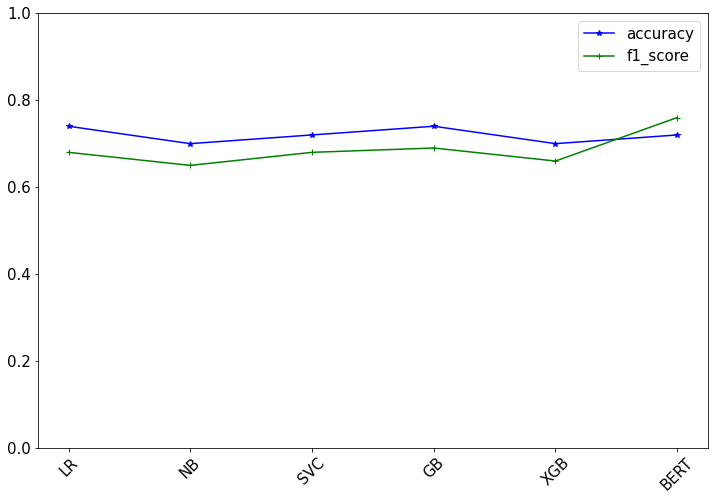

In [32]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["font.size"] = (15)
plt.ylim(0.0, 1.0)
plt.plot( 'model', 'accuracy', data=results, marker='*', color='blue', label="accuracy")
plt.plot( 'model', 'f1_score', data=results, marker='+', color='green', label="f1_score")
plt.xticks(rotation=45)
plt.legend();

In [33]:
plt.show()
plt.savefig('abusive_language-1.png');

<Figure size 864x576 with 0 Axes>

## Hyperparameter tuning

In [34]:
# Logistic Regression
param_grid = {
    'C': np.logspace(-3, 3, 7), 
    'penalty':['l2'],
    'solver': ['liblinear', 'newton-cg']
}
logreg = LogisticRegression(max_iter=500)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
logreg_cv.fit(x_train_vectorized, y_train)
logreg_cv.best_params_

{'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [35]:
lr_classifier = LogisticRegression(**logreg_cv.best_params_)
lr_classifier.fit(x_train_vectorized, y_train)

y_pred_test = lr_classifier.predict(x_valid_transformed)

accuracy = accuracy_score(y_pred_test, y_valid)
f_score = f1_score(y_pred_test, y_valid)

print(f'''Logistic Regression
Accuracy: {accuracy:.2f}
f1_score: {f_score:.2f}''')

Logistic Regression
Accuracy: 0.72
f1_score: 0.68
